**Tranfer learning vs CNN desde cero**

En este proyecto realizaremos un clasificador de imagenes de jirafas vs babuinos de dos formas diferentes transfer learning y CNN entrenda desde cero

Importamos es set de datos a colab usaremos es signo de exclamacion para ejecutar comandos de linux en colab

In [1]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/babuino/
  inflating: dataset/babuino/08-03-24-babuino.jpg  
  inflating: dataset/babuino/43pcixugf8771.jpg  
  inflating: dataset/babuino/63ab166040228.jpeg  
  inflating: dataset/babuino/71MkbHIpL._AC_UF10001000_QL80_.jpg  
  inflating: dataset/babuino/360_F_18253442_WVLdKgWFsUVOZDFz06wrHDHMtK8rKDjh.jpg  
  inflating: dataset/babuino/1200px-Papio_hamadryas_eating_an_apple.JPG.jpg  
  inflating: dataset/babuino/6292_machos-de-mono-babuino-protegiendo.jpg  
  inflating: dataset/babuino/1007184.png  
  inflating: dataset/babuino/20120923-k529677.webp  
  inflating: dataset/babuino/107949058-a-baboon-monkey-is-sitting-on-a-rock-and-eating-a-leaf.jpg  
  inflating: dataset/babuino/2025121606195569452.jpg  
  inflating: dataset/babuino/ape-653705_1280.jpg  
  inflating: dataset/babuino/Asi-se-alimentaba-hace-millones-de-anos-un-babuino-ya-extinto.jpg  
  inflating: dataset/babuino/baboon.jpg  
  inflating: dataset/babuino/bab

In [2]:
!rm -rf dataset.zip

In [3]:
# Una vez listo el set de datos dabemos prepararlo para su uso
# Lo dividiremos en 2 entrenamiento y prubas
from IPython.core.interactiveshell import re

#Aumento de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Data set generador
datagen = ImageDataGenerator(
    # Normaliza los píxeles de [0, 255] a [0, 1] para facilitar el aprendizaje
    rescale=1./255,
    # Gira la imagen aleatoriamente hasta 10 grados
    rotation_range=10,
    # Desplaza la imagen horizontalmente (máximo 15% del ancho total)
    width_shift_range=0.15,
    # Desplaza la imagen verticalmente (máximo 15% del alto total)
    height_shift_range=0.15,
    # Aplica una distorsión de estiramiento o cizalladura
    shear_range=0.15,
    # Zoom aleatorio: entre 0.7 (alejar) y 1.3 (acercar)
    zoom_range=[0.7, 1.3],
    # Invierte la imagen horizontalmente y verticalmente(efecto espejo)
    horizontal_flip=True,
    vertical_flip=False,
    # Reserva el 20% de las imágenes para pruebas/validación
    validation_split=0.2
)

# Crea el generador para los datos de entrenamiento
data_gen_ent = datagen.flow_from_directory(
    # Ruta de la carpeta principal que contiene las subcarpetas de imágenes
    "/content/dataset",
    # Redimensiona todas las imágenes a 224x224 píxeles (estándar para modelos como ResNet o MobileNet)
    target_size=(224, 224),
    # Número de imágenes que se procesan a la vez antes de actualizar el modelo
    batch_size=32,
    # Mezcla el orden de las imágenes para que el modelo no aprenda patrones por el orden de los archivos
    shuffle=True,
    # Indica que este generador usará el 80% de los datos destinados a entrenamiento (según el validation_split anterior)
    subset="training"
)

# Crea el generador para los datos de prueba
data_gen_pru = datagen.flow_from_directory(
    # Ruta de la carpeta principal que contiene las subcarpetas de imágenes
    "/content/dataset",
    # Redimensiona todas las imágenes a 224x224 píxeles (estándar para modelos como ResNet o MobileNet)
    target_size=(224, 224), # es necesario escalarlas a 224 * 224 px ya que el modelo base usado en transfer learning lo va a nesecitar en este tamaño
    # Número de imágenes que se procesan a la vez antes de actualizar el modelo
    batch_size=32,
    # Mezcla el orden de las imágenes para que el modelo no aprenda patrones por el orden de los archivos
    shuffle=True,
    # Indica que este generador usará el 80% de los datos destinados a entrenamiento (según el validation_split anterior)
    subset="validation"
)

Found 724 images belonging to 2 classes.
Found 179 images belonging to 2 classes.


Ya que tenemos los datos en entrenamiento y prueba rescalados imprimimos algunas imagenes para ver que se vean correctamente y que su etiqueta sea correcta.
[1,0] babuino y [0,1] jirafa

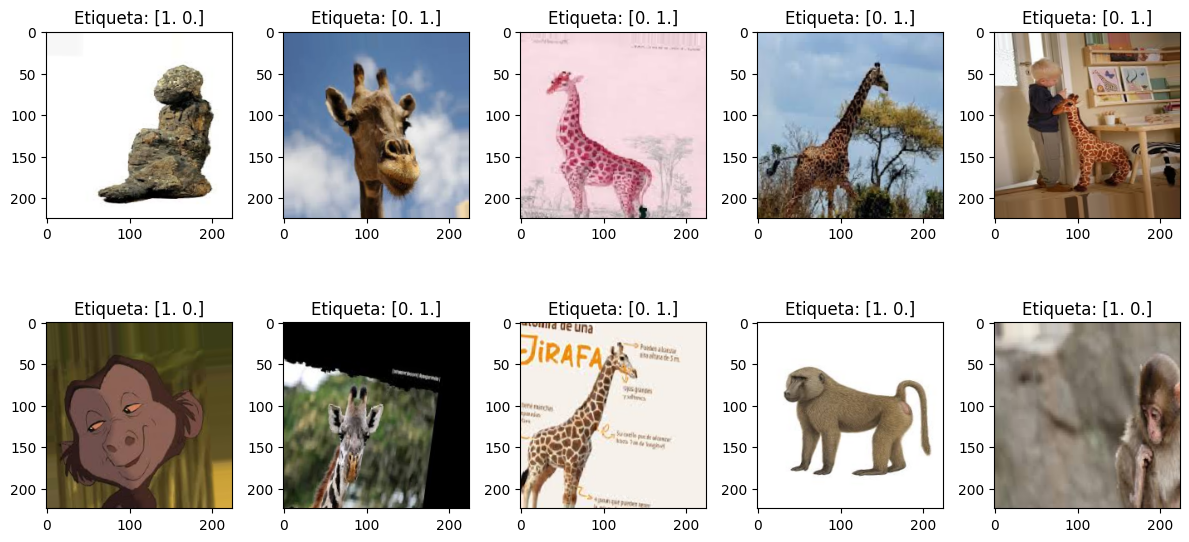

In [4]:
import matplotlib.pyplot as plt

# Extraemos un paquete (batch) de imágenes y etiquetas del generador
for imagenes, etiquetas in data_gen_ent:
    plt.figure(figsize=(12, 6)) # Ajustamos el tamaño de la figura para que se vea mejor

    for i in range(10):
        plt.subplot(2, 5, i+1)

        # Mostramos la imagen
        plt.imshow(imagenes[i])

        # Agregamos la etiqueta como título.
        # Si las etiquetas son arreglos (ej: [1, 0]), usamos etiquetas[i].argmax()
        # para obtener el número 0 o 1 directamente.
        plt.title(f"Etiqueta: {etiquetas[i]}")

    break # Solo queremos ver el primer batch

plt.tight_layout() # Ajusta los elementos para que no se amontonen
plt.show()

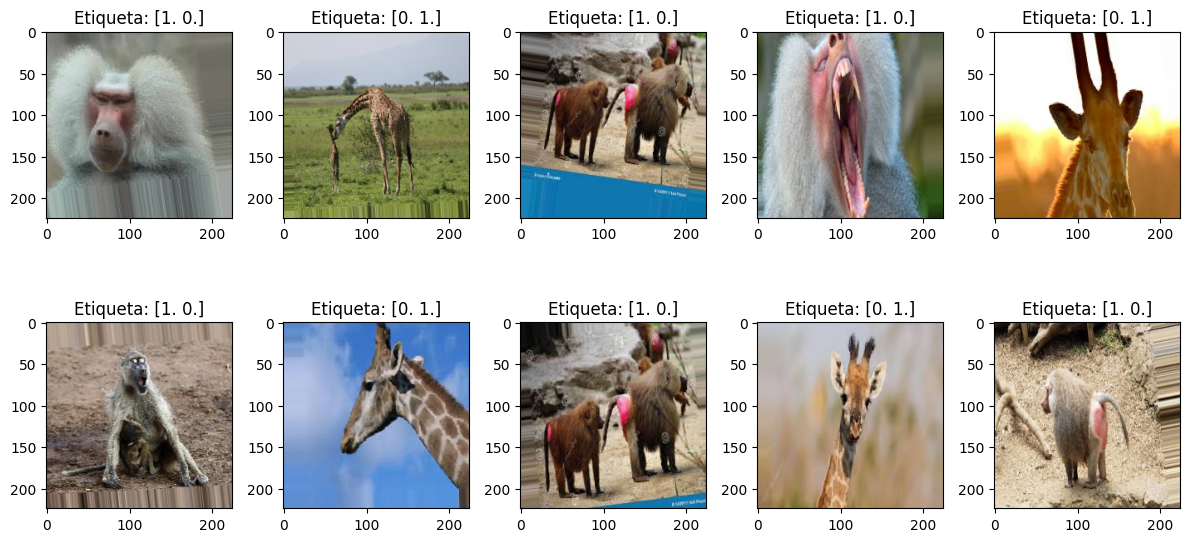

In [5]:
# Extraemos un paquete (batch) de imágenes y etiquetas del generador
for imagenes, etiquetas in data_gen_pru:
    plt.figure(figsize=(12, 6)) # Ajustamos el tamaño de la figura para que se vea mejor

    for i in range(10):
        plt.subplot(2, 5, i+1)

        # Mostramos la imagen
        plt.imshow(imagenes[i])

        # Agregamos la etiqueta como título.
        # Si las etiquetas son arreglos (ej: [1, 0]), usamos etiquetas[i].argmax()
        # para obtener el número 0 o 1 directamente.
        plt.title(f"Etiqueta: {etiquetas[i]}")

    break # Solo queremos ver el primer batch

plt.tight_layout() # Ajusta los elementos para que no se amontonen
plt.show()

Ya que confirmamos que las imagenes estan bien etiquetadas y con la escala correcta empezaremos diseñando una CNN completamente nueva y sin entrenamiento

In [6]:
import tensorflow as tf

In [7]:
modeloCNN = tf.keras.models.Sequential([
    # Creamos una capa convolucional de entrada donde 3 = RGB y 224 * 224 = PX
    # Ativacion relu para que devuelva 0 o 1 seguna las clsificaciones
    # Un estandar de 32 "filtros" aplicados con una matrix de 3 * 3 para obtener caracteriticas
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    # Las cartacteriticas mas fuertes pasan a la siguinete capas
    # Se calcula obteneiendo el valor mas alto en una matrix 2 * 2 aplicadas a las imagenes con "filtros"
    tf.keras.layers.MaxPooling2D(2, 2),

    # El proseso se repite el las capas convolucionales siguientes para obtener mas caracteristicas
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),


    # Las caracteriticas se "apalanan" y se pasan a una red Densa para tomar una decicion
    tf.keras.layers.Flatten(),
    #Se reciven las caracteriticas
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    # Finalmete se toma la decion usando el activador sofmax para clasificar que hay en la imagen
    tf.keras.layers.Dense(2, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compilamos es modelo
modeloCNN.compile(
    # El optimizador ajusta los pesos de la red para reducir el error.
    # 'adam' es el estándar actual porque es eficiente y se adapta solo.
    optimizer=tf.keras.optimizers.Adam(1e-3),

    # La función de pérdida mide qué tan "equivocado" está el modelo.
    # SparseCategoricalCrossentropy se usa cuando tus etiquetas son números enteros (0, 1, 2...).
    loss="categorical_crossentropy",

    # Métrica para evaluar el rendimiento. El 'accuracy' (precisión) indica
    # el porcentaje de imágenes clasificadas correctamente.
    metrics=['accuracy']
)

Una vez creado y compilado toca entrenar y ver que tal se desempeña

In [9]:
entrenamiento = modeloCNN.fit(data_gen_ent, epochs=20,
                              batch_size=32,
                              validation_data=data_gen_pru)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 853ms/step - accuracy: 0.5088 - loss: 1.9916 - val_accuracy: 0.6145 - val_loss: 0.6548
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 561ms/step - accuracy: 0.6361 - loss: 0.6377 - val_accuracy: 0.8268 - val_loss: 0.5588
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 552ms/step - accuracy: 0.7141 - loss: 0.5813 - val_accuracy: 0.8603 - val_loss: 0.4099
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 552ms/step - accuracy: 0.7754 - loss: 0.5027 - val_accuracy: 0.9162 - val_loss: 0.2575
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 567ms/step - accuracy: 0.7952 - loss: 0.4654 - val_accuracy: 0.8771 - val_loss: 0.3586
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 575ms/step - accuracy: 0.8129 - loss: 0.4112 - val_accuracy: 0.7989 - val_loss: 0.4385
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 570ms/step - accuracy: 0.7859 - loss: 0.4707 - val_accuracy: 0.8994 - val_loss: 0.2398
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 571ms/step - accuracy: 0.8148 - loss: 0.4183 - val_accu

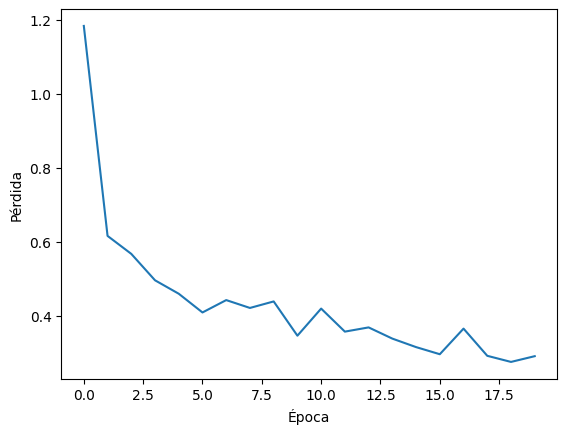

In [10]:
import matplotlib.pyplot as plt

plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.plot(entrenamiento.history['loss'])


Al final podemos apreciar muy buenos resultados donde tanto con los valores de perdida y accurancy tanto con el set de entrenamiento como con el de pruavas logra muy buenos resultados, la pregunta ahora es ¿que tan bien realmente predice ahora?

Para comprobarlo usaremos el set de datos de pruebas para evaluar sus resultados con datos que tecnicamento nunca a visto

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


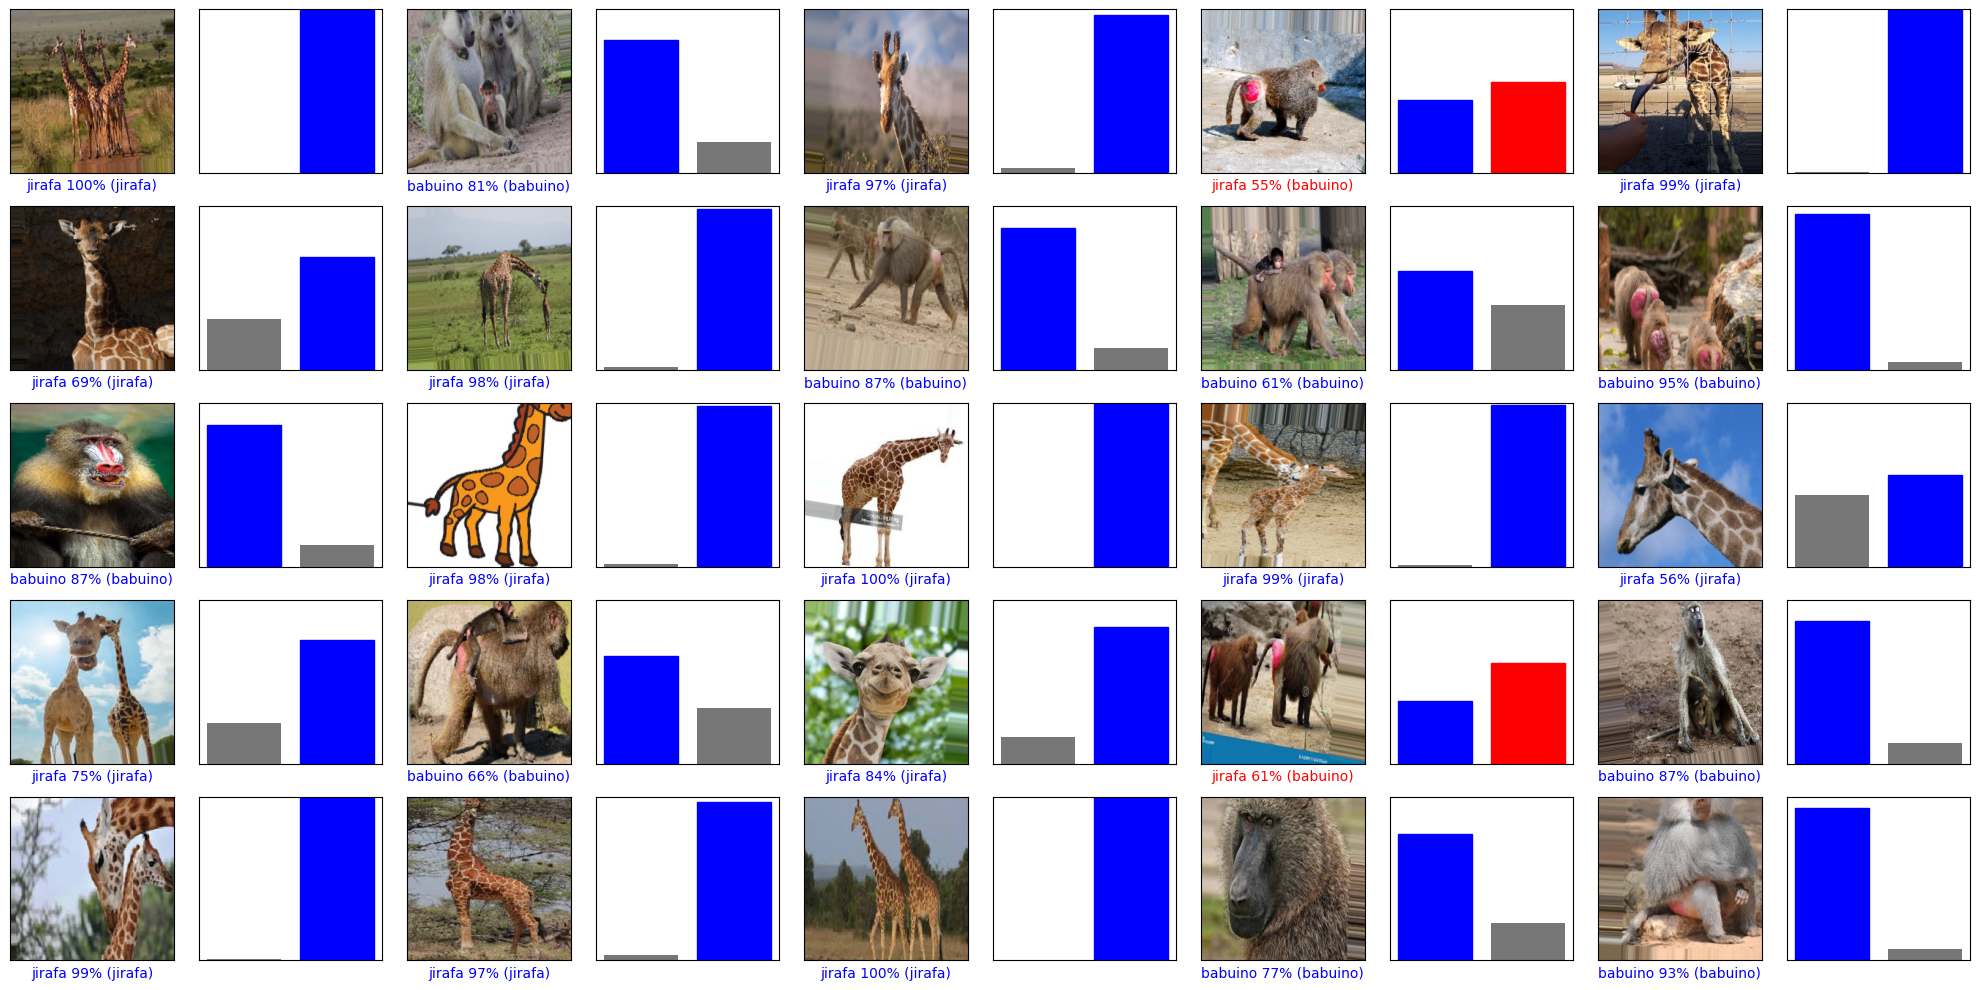

In [11]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np
import matplotlib.pyplot as plt

# Define class names based on alphabetical order of folders in data_gen_pru
nombres_clases = list(data_gen_pru.class_indices.keys())

imagenes_prueba, etiquetas_prueba = next(iter(data_gen_pru)) # Corrected assignment
# labels from data_gen_pru are already numpy arrays, no need to call .numpy()
# imagenes_prueba = imagenes_prueba.numpy() # This line is not needed
# etiquetas_prueba = etiquetas_prueba.numpy() # This line is not needed
predicciones = modeloCNN.predict(imagenes_prueba) # Corrected model name

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary) # Removed [...,0] as images are RGB

  etiqueta_prediccion = np.argmax(arr_predicciones)
  etiqueta_real_idx = np.argmax(etiqueta_real) # Convert one-hot to index

  if etiqueta_prediccion == etiqueta_real_idx:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real_idx]), # Use index for real label
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(len(nombres_clases)), arr_predicciones, color="#777777") # Range should be num_classes
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)
  etiqueta_real_idx = np.argmax(etiqueta_real) # Convert one-hot to index

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real_idx].set_color('blue') # Use index for real label

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)
plt.tight_layout()
plt.show()

Al final de la evaluacion podemos apreciar que el modelo realmente aprendio a clazificar aunque tras correr varias veces el scrip para ver distntas iamgenes suele fallar bastante esto puede significar falta de experiencia mas epocas podrian ayudar aunque el tamaño del dataset es algo pequeño lo que podria afectar un poco

**Transfer Learning**

Ahora usaremos un modelo "mobilenetV2" un modelo de clasificacion de imagenes entrendo por google como modelo base para clasificar jirafas o babuinos cabria esperar mejores resultados en la prediciones con menos nececidad de entrenamiento

In [12]:
# Caragar modelo base
base_modelo = tf.keras.applications.MobileNetV2(# mobilenetv2 modelo entrenado por google capaz de clasificar mas de 1000 tipos de imagenes
    input_shape=(224, 224, 3), # Ingresamos la entrada del modelo imagenes de 224 * 224 px y 3 RGB color
    include_top=False, # Retiramos la ultima capa encargada de clasificar mas de 1000 imagenes
    weights='imagenet' # Los pesos y sesgos que ya entreno google
)

# 1. Definir la entrada
inputs = tf.keras.Input(shape=(224, 224, 3))

# 2. Pasar la entrada por el modelo base (MobileNetV2)
# training=False asegura que las capas de BatchNormalization no se alteren
x = base_modelo(inputs, training=False)
base_modelo.trainable = False

# 3. Convertir las características 2D a un vector (necesario antes de capas Densas)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# --- NUEVAS CAPAS DENSAS ---

# Capa de 128 neuronas con activación ReLU
x = tf.keras.layers.Dense(128, activation='relu')(x)

# ---------------------------

# 4. Capa de salida (ajusta el número '2' si tienes más clases)
# Usamos Softmax para obtener probabilidades
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

# 5. Crear el modelo final vinculando la entrada y la salida
modeloTF = tf.keras.Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
# Compilamos es modelo
modeloTF.compile(
    # El optimizador ajusta los pesos de la red para reducir el error.
    # 'adam' es el estándar actual porque es eficiente y se adapta solo.
    optimizer=tf.keras.optimizers.Adam(1e-3),

    # La función de pérdida mide qué tan "equivocado" está el modelo.
    # SparseCategoricalCrossentropy se usa cuando tus etiquetas son números enteros (0, 1, 2...).
    loss="categorical_crossentropy",

    # Métrica para evaluar el rendimiento. El 'accuracy' (precisión) indica
    # el porcentaje de imágenes clasificadas correctamente.
    metrics=['accuracy']
)

Ya creado el modelo y compilado solo queda entrenarlo al igual que con el modelo anterior lo entrenarmos por 20 epocas y veremos su desempeño

In [14]:
entrenamiento = modeloTF.fit(data_gen_ent, epochs=20,
                              batch_size=32,
                              validation_data=data_gen_pru)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7986 - loss: 0.4166 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 551ms/step - accuracy: 0.9934 - loss: 0.0314 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 540ms/step - accuracy: 0.9880 - loss: 0.0321 - val_accuracy: 0.9944 - val_loss: 0.0068
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 544ms/step - accuracy: 0.9928 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 553ms/step - accuracy: 0.9919 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 550ms/step - accuracy: 0.9952 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 544ms/step - accuracy: 0.9971 - loss: 0.0109 - val_accuracy: 1.0000 - val_loss: 5.5752e-04
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 548ms/step - accuracy: 0.9927 - loss: 0.0236 - val_acc

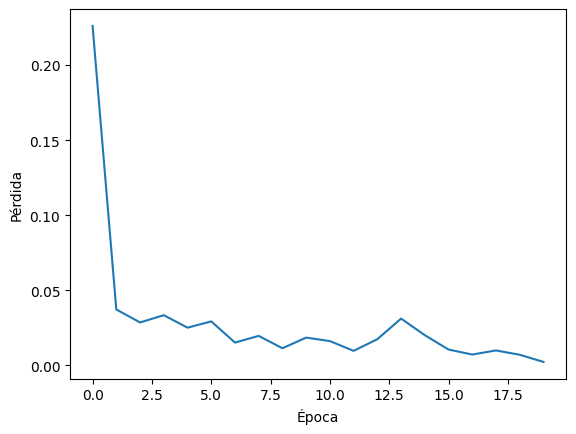

In [15]:
import matplotlib.pyplot as plt

plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.plot(entrenamiento.history['loss'])


Tras estrenar el modelo vemos un muy buen desempeño en el aprendizaje con respecto al modelo CNN podemos apreciar que desde el primer momento tiene buenos valores de accurancy y loss tanto en el set de enternamiento como en el de pruebas, aun asi realizaremos una prueba mas grafica para ver su desempeño, por cierto 20 epocas de entrenamiento es un despropocito ya que desde epocas anteriores ya lograbamos buen desempeño

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


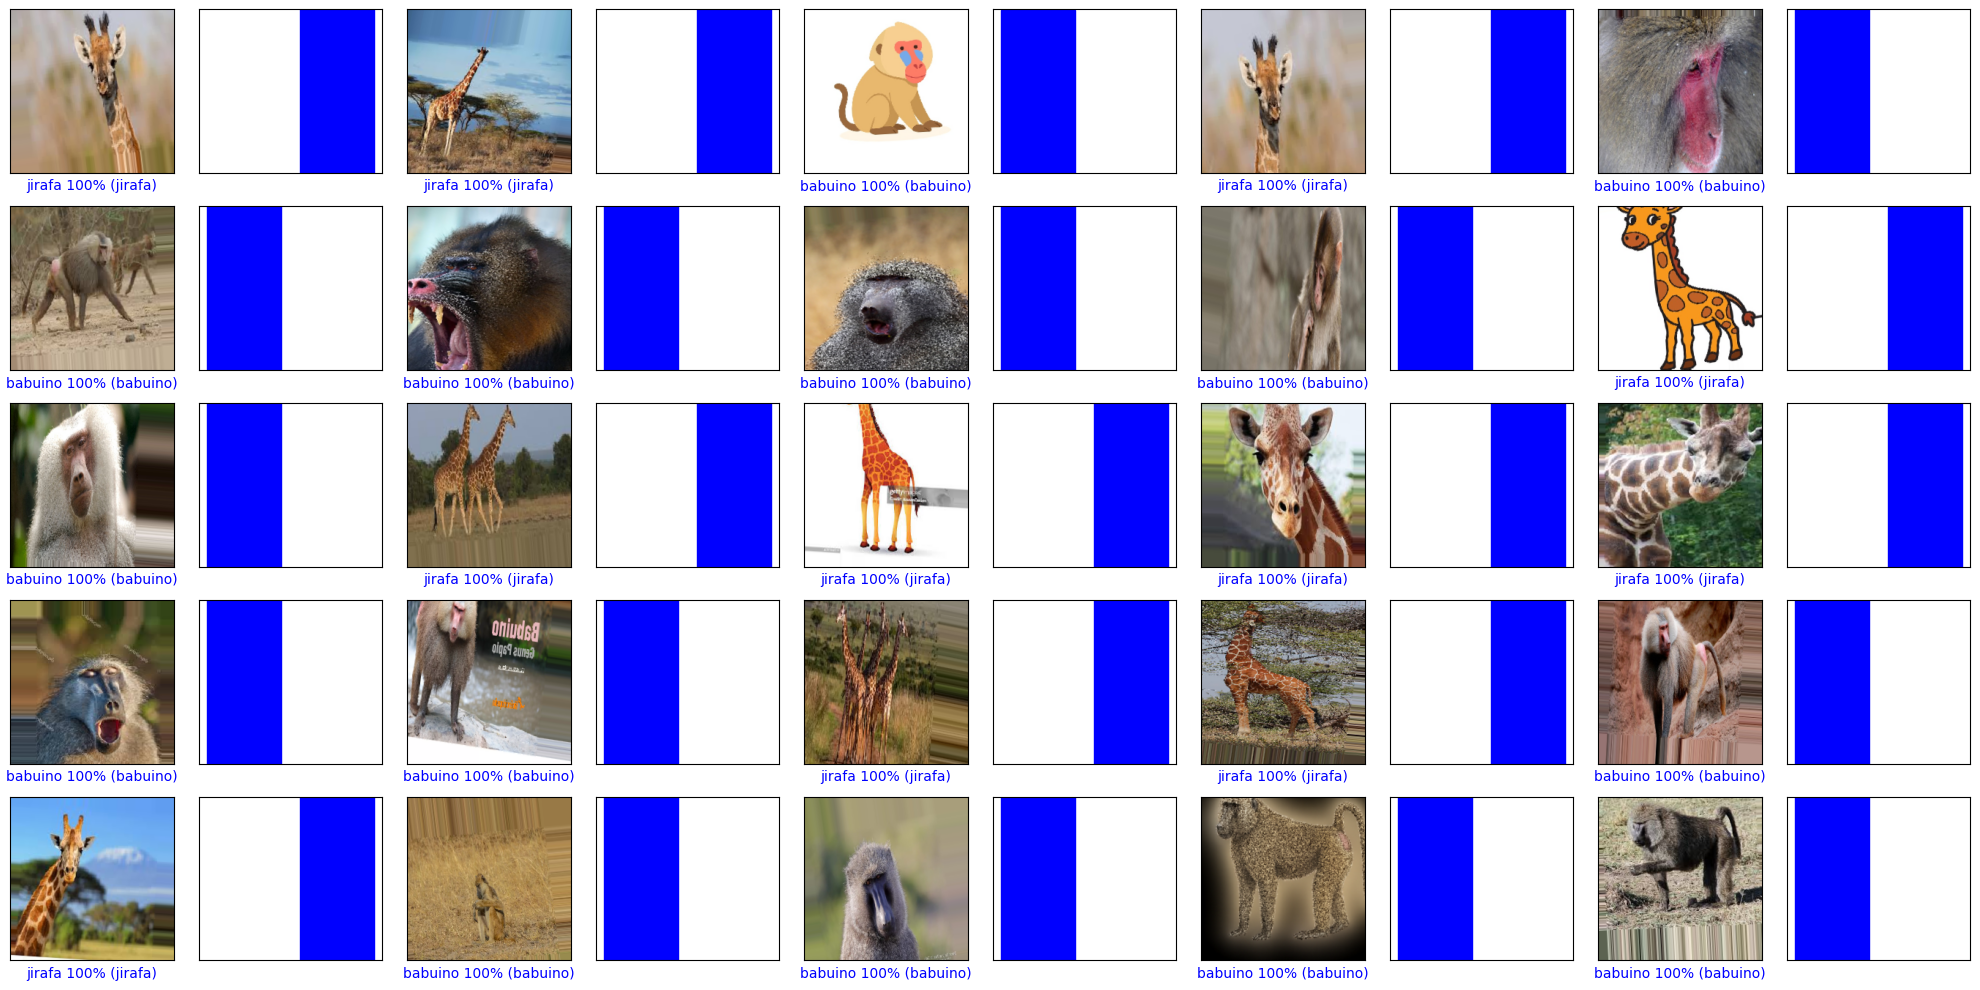

In [18]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np
import matplotlib.pyplot as plt

# Define class names based on alphabetical order of folders in data_gen_pru
nombres_clases = list(data_gen_pru.class_indices.keys())

imagenes_prueba, etiquetas_prueba = next(iter(data_gen_pru)) # Corrected assignment
# labels from data_gen_pru are already numpy arrays, no need to call .numpy()
# imagenes_prueba = imagenes_prueba.numpy() # This line is not needed
# etiquetas_prueba = etiquetas_prueba.numpy() # This line is not needed
predicciones = modeloTF.predict(imagenes_prueba) # Corrected model name

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary) # Removed [...,0] as images are RGB

  etiqueta_prediccion = np.argmax(arr_predicciones)
  etiqueta_real_idx = np.argmax(etiqueta_real) # Convert one-hot to index

  if etiqueta_prediccion == etiqueta_real_idx:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real_idx]), # Use index for real label
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(len(nombres_clases)), arr_predicciones, color="#777777") # Range should be num_classes
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)
  etiqueta_real_idx = np.argmax(etiqueta_real) # Convert one-hot to index

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real_idx].set_color('blue') # Use index for real label

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)
plt.tight_layout()
plt.show()

Tras realizar mutiples pruebas graficas podemos apreciar no solo un alto nivel de confianza sino tambien que el modelo parece no cometer errores

**Concluciones:**

En este proyecto se comparó el desempeño de una red neuronal convolucional entrenada desde cero con un modelo basado en Transfer Learning utilizando MobileNetV2.

La CNN entrenada desde cero logró aprender patrones básicos del dataset, sin embargo, presentó dificultades para generalizar correctamente debido al tamaño limitado de los datos, mostrando inestabilidad en la pérdida y errores con baja confianza en algunos casos.

Por otro lado, el modelo de Transfer Learning demostró un aprendizaje significativamente más rápido y estable, alcanzando valores de pérdida muy bajos y predicciones altamente confiables incluso en imágenes con variaciones de ángulo, iluminación y estilo (incluyendo ilustraciones).

Tras ajustar la arquitectura de la cabeza del modelo, congelar correctamente las capas preentrenadas y reducir la tasa de aprendizaje, se logró mejorar la generalización y evitar la sobreconfianza del modelo.

Los resultados confirman que el uso de Transfer Learning es una estrategia más eficiente y robusta para problemas de clasificación de imágenes con datasets pequeños o medianos.

In [21]:
# Guardamos el modelo

# Usando el formato .keras (recomendado para TF 2.x)
modeloCNN.save('mi_modelo.keras')
modeloTF.save('mi_modelo_TL.keras')
# Usando el formato SavedModel (carpeta)
modeloCNN.export('mi_modelo_savedmodel')
modeloTF.export('mi_modelo_TL_savedmodel')
# Usando el formato HDF5
modeloCNN.save('mi_modelo.h5')
modeloTF.save('mi_modelo_TL.h5')
# Guardando solo los pesos
modeloCNN.save_weights('mi_modelo_CNN.weights.h5')
modeloTF.save_weights('mi_modelo_TL.weights.h5')

Saved artifact at 'mi_modelo_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  136386894858384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136386894859536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136386894857424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136386894857040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136386894856848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136386894858960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136386894859920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136386894858768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136386894859152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136386894858192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1363869100